# Imports And Consts

In [1]:
RESULTS_COLUMNS = [
    "score",
    "numberOfTruePositives",
    "accuracy",
    "precision",
    "numberOfFeatures",
    "model",
    "model_parameters",
    "feature_selector",
    "selector_parameters",
]

In [2]:
import functions
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from sklearn.feature_selection import f_classif, mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import xgboost as xgb

# Load Data

load the training and test data in a format specified by task description

In [3]:
with open("./Dataset/x_test.txt") as file:
    X_test = [[float(digit) for digit in line.split()] for line in file]


with open("./Dataset/x_train.txt") as file:
    X_train = [[float(digit) for digit in line.split()] for line in file]


with open("./Dataset/y_train.txt") as file:
    y_train = [[float(digit) for digit in line.split()] for line in file]

In the X_test there are 500 features and 5000 observations, y_train contains 5000 values, X_train contains 500 features and 5000 observations

In [4]:
print("X_test datapoints:", len(X_test), " features:", len(X_test[0]))
print("X_train datapoints:", len(X_train), " features:", len(X_train[0]))
print("y_train datapoints:", len(y_train))

X_test datapoints: 5000  features: 500
X_train datapoints: 5000  features: 500
y_train datapoints: 5000


# XGBoost

In [17]:
y_train_ravel = np.ravel(y_train, order="C")
y_train_ravel = y_train_ravel.astype(int)

In [37]:
from sklearn.model_selection import train_test_split

selector = functions.SelectKBest(k=2)

X_new = selector.fit_transform(X_train, y_train_ravel)
X_new = functions.RobustScaler().fit_transform(X_new, y_train_ravel)
X_t, X_te, y_t, y_te = train_test_split(
    X_new, y_train_ravel, random_state=42, test_size=0.33
)

In [65]:
dtrain = xgb.DMatrix(X_t, label=y_t)
param = {"max_depth": 2, "eta": 0.001, "objective": "binary:logistic"}
param["nthread"] = 4
param["eval_metric"] = "auc"
num_round = 10
clf = xgb.XGBClassifier()
clf.set_params(**param)
bst = clf.fit(X_t, y_t)

In [66]:
dtest = xgb.DMatrix(X_te)
ypred = clf.predict_proba(X_te)

In [67]:
functions.getScoreLimited(y_te, ypred, len(X_new[0]), 0.45)

(199, 0.48623853211009177)

# Batch 1

## Consts

In [6]:
RESULTS_FILENAME = "./Results/Limited/XGBoost/results-11"

## Experiment

### Parameters

In [7]:
# MLPClassifier

activation = ["relu", "tanh"]
solver = ["adam"]
alpha = [0.01]
learning_rate = ["adaptive"]
learning_rate_init = [0.01, 0.001]
hidden_layer_sizes = [(100,), (50,), (20,)]
max_iter = [1600]
random_state = [42]
mlpClassifierParameters = functions.generateParameters(
    [
        activation,
        solver,
        alpha,
        learning_rate,
        learning_rate_init,
        hidden_layer_sizes,
        max_iter,
        random_state,
    ],
    globals(),
)

# XGBOOST
max_depth = [2, 3]
eta = [0.001, 0.0001, 0.01]
objective = ["binary:logistic"]
nthread = [4, 2, 8]
eval_metric = ["auc"]
gamma = [0, 2, 10]
min_child_weight = [1, 5, 10]
max_delta_step = [0, 2, 8]
scale_pos_weight = [1, 1.2, 1.5]
refresh_leaf = [0, 1]
process_type = ["defualt", "update"]
num_parallel_tree = [1, 2, 5]
max_leaves = [0, 2, 5]
tree_method = ["exact", "approx", "hist"]

xGBoostParameters = functions.generateParameters(
    [max_depth, eta, objective, nthread, eval_metric], globals()
)


models = [
    {"model": functions.ModelType.MLPClassifier, "parameters": mlpClassifierParameters},
    {"model": functions.ModelType.XGBoost, "parameters": xGBoostParameters},
]

In [8]:
# KBest
k = [2, 3]
score_func = [mutual_info_classif]
kBestParameters = functions.generateParameters([score_func, k], globals())

# FPR

# mutual_info_classif seems to break for FPR but maybe try to run these without StandardScaler?
score_func = [f_classif]
alpha = [0.01]
fprParameters = functions.generateParameters([score_func, alpha], globals())


# RFE
estimator = [SVC(kernel="linear")]
n_features_to_select = [2, 3]
step = [0.9]
rfeParameters = functions.generateParameters(
    [estimator, n_features_to_select, step], globals()
)


featureSelectors = [
    {"model": functions.FeatureSelectorType.KBest, "parameters": kBestParameters},
    {"model": functions.FeatureSelectorType.FPR, "parameters": fprParameters},
    {"model": functions.FeatureSelectorType.RFE, "parameters": rfeParameters},
]

In [9]:
scalers = [
    {"model": functions.Scaler.NoScaling, "parameters": [{}]},
    {"model": functions.Scaler.Standard, "parameters": [{}]},
    {"model": functions.Scaler.Robust, "parameters": [{}]},
]

degree = [2]

polynomialParameters = functions.generateParameters([degree], globals())

featureGenerators = [
    {"model": functions.FeatureGenerator.NoFeatureGeneration, "parameters": [{}]},
    {
        "model": functions.FeatureGenerator.Polynomial,
        "parameters": polynomialParameters,
    },
]

### Conducting the experiment

In [41]:
y_train_ravel = np.ravel(y_train, order="C")
y_train_ravel = y_train_ravel.astype(int)

In [16]:
%%time
results = functions.conductExperimentsWithScalersAndGenerators(
    models=models,
    featureSelectors=featureSelectors,
    X_orig=X_train,
    y_orig=y_train_ravel,
    scalers=scalers,
    featureGenerators=featureGenerators,
    getLimitedScore=True,
    limit=0.45,
)
with open(RESULTS_FILENAME, "wb") as f:
    pickle.dump(results, f)

Performed Experiment 1/900(approx) took (s): model: 0.97 selector 15.69 with: FeatureSelectorType.KBest {'score_func': <function mutual_info_classif at 0x00000125E97BD620>, 'k': 2} ModelType.MLPClassifier {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100,), 'max_iter': 1600, 'random_state': 42} Scaler.NoScaling {} FeatureGenerator.NoFeatureGeneration {}
Performed Experiment 2/900(approx) took (s): model: 0.54 selector 15.69 with: FeatureSelectorType.KBest {'score_func': <function mutual_info_classif at 0x00000125E97BD620>, 'k': 2} ModelType.MLPClassifier {'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (50,), 'max_iter': 1600, 'random_state': 42} Scaler.NoScaling {} FeatureGenerator.NoFeatureGeneration {}
Performed Experiment 3/900(approx) took (s): model: 0.48 selector 15.69 with: FeatureSelectorType.KBest {'sco

c:\Users\Patryk\Documents\Repos\advml-proj-2\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1600) reached and the optimization hasn't converged yet.
  warnings.warn(


Performed Experiment 521/900(approx) took (s): model: 29.53 selector 0.35 with: FeatureSelectorType.FPR {'score_func': <function f_classif at 0x00000125E97BF2E0>, 'alpha': 0.01} ModelType.MLPClassifier {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (50,), 'max_iter': 1600, 'random_state': 42} Scaler.Robust {} FeatureGenerator.Polynomial {'degree': 2}
Performed Experiment 522/900(approx) took (s): model: 16.27 selector 0.35 with: FeatureSelectorType.FPR {'score_func': <function f_classif at 0x00000125E97BF2E0>, 'alpha': 0.01} ModelType.MLPClassifier {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (20,), 'max_iter': 1600, 'random_state': 42} Scaler.Robust {} FeatureGenerator.Polynomial {'degree': 2}
Performed Experiment 523/900(approx) took (s): model: 0.13 selector 0.35 with: FeatureSelectorType.FPR {'score_func'

## Results

In [10]:
with open(RESULTS_FILENAME, "rb") as input_file:
    results = pickle.load(input_file)

In [11]:
resultsDf = pd.DataFrame(
    results,
    columns=functions.RESULTS_COLUMNS,
)

### Detailed Results

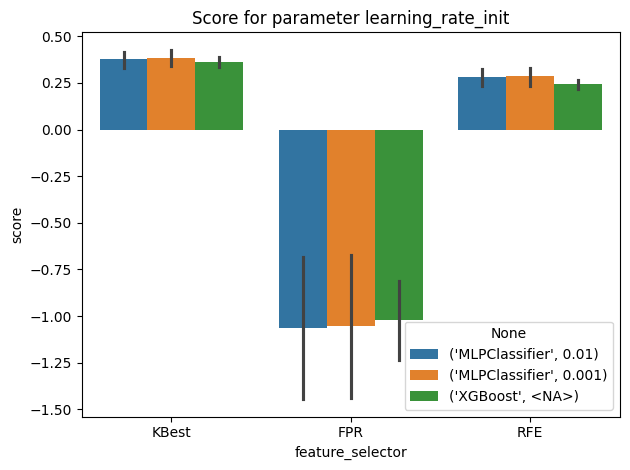

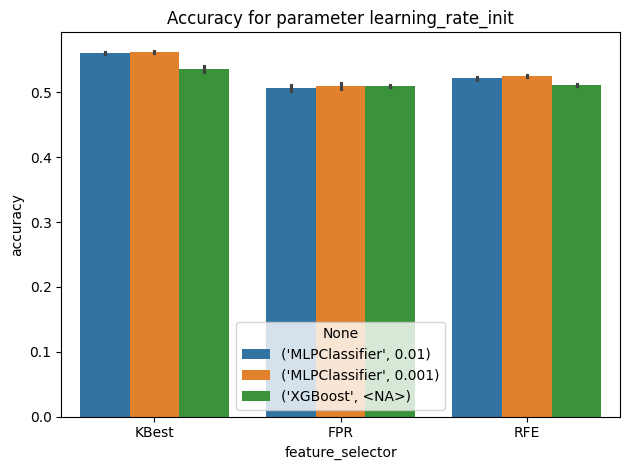

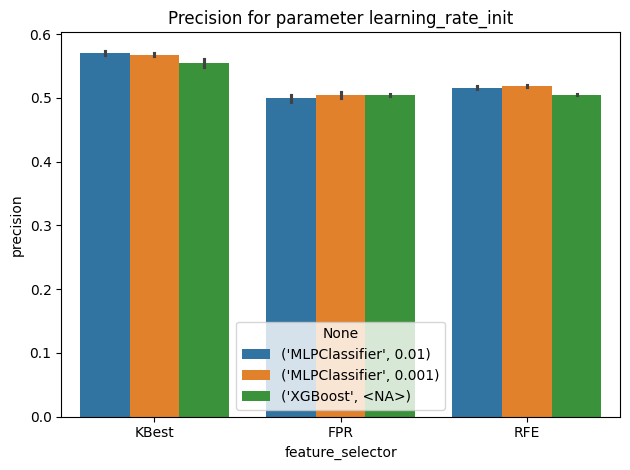

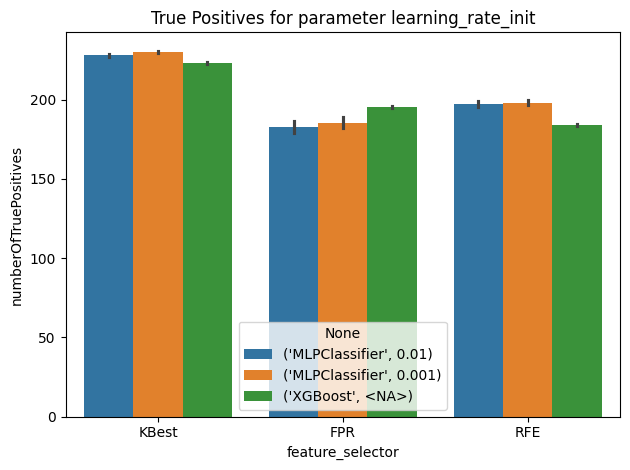

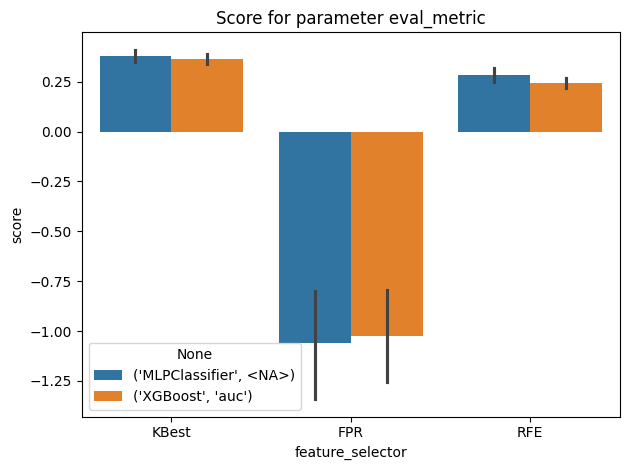

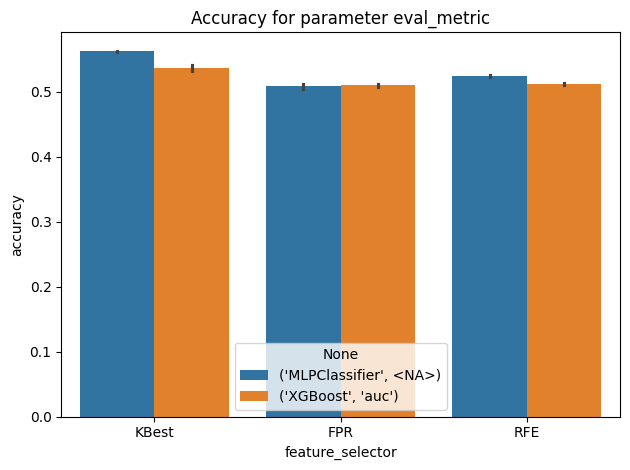

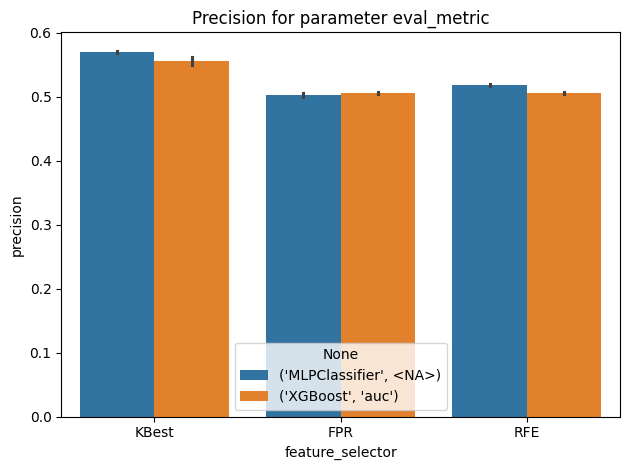

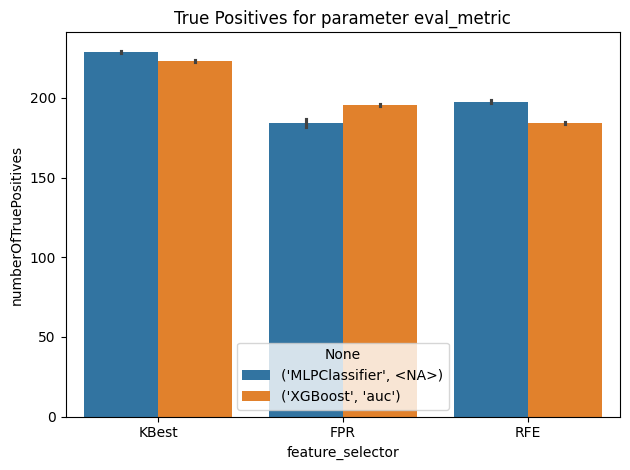

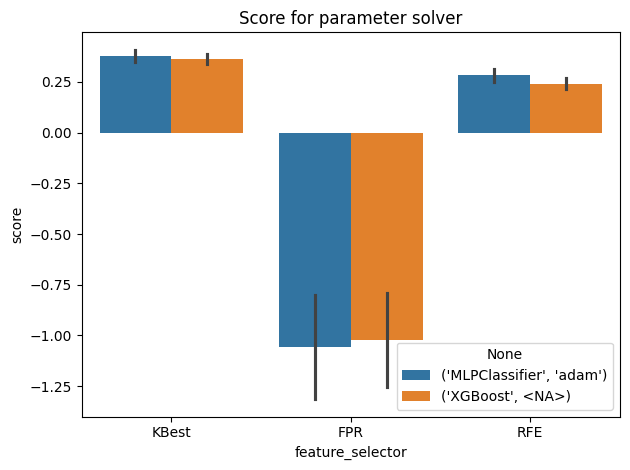

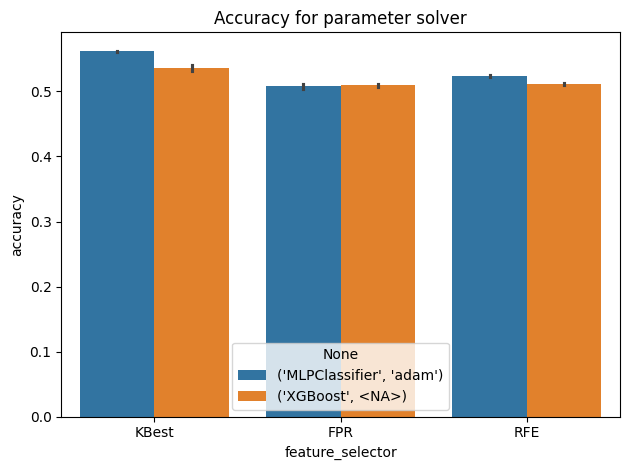

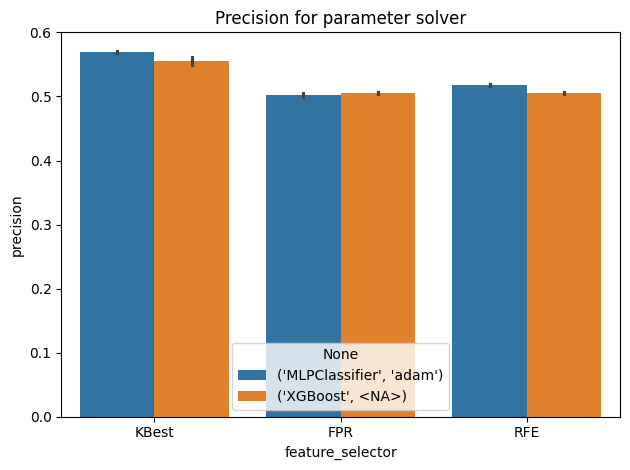

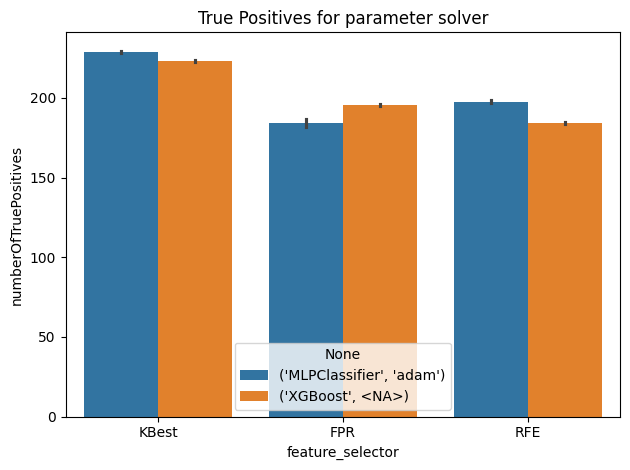

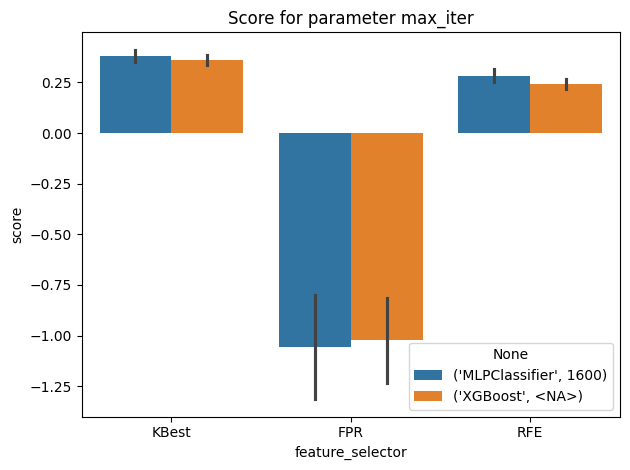

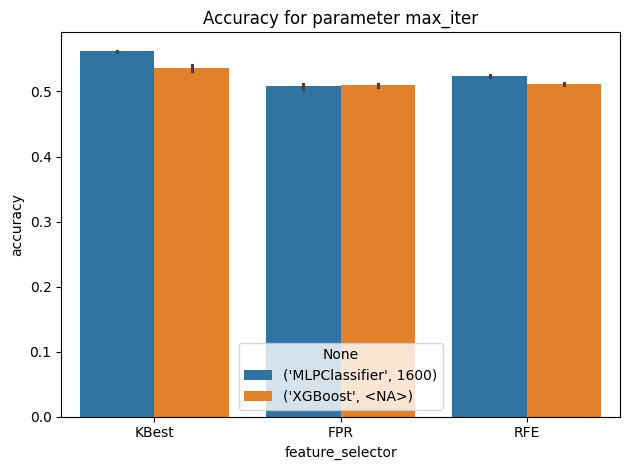

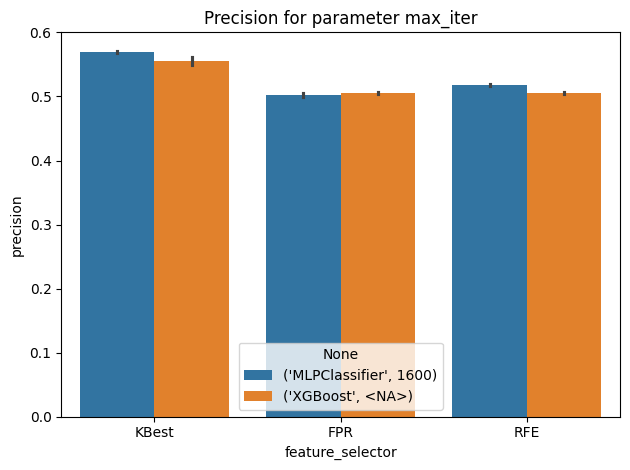

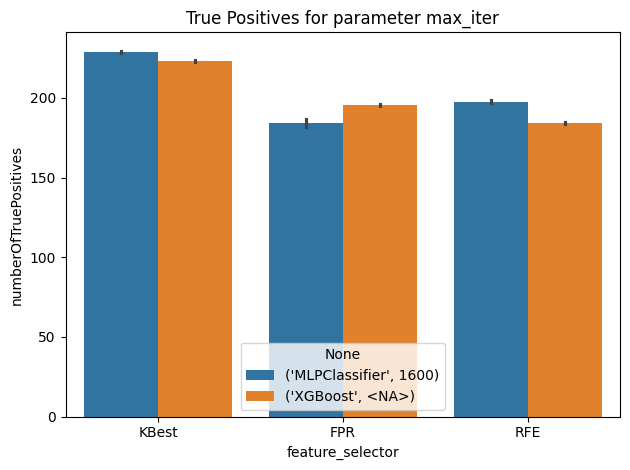

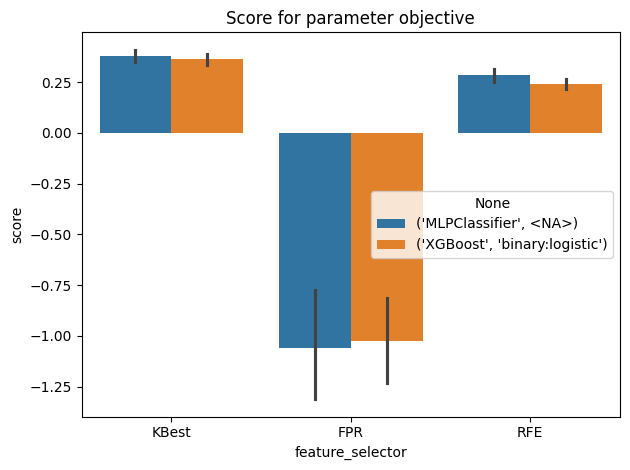

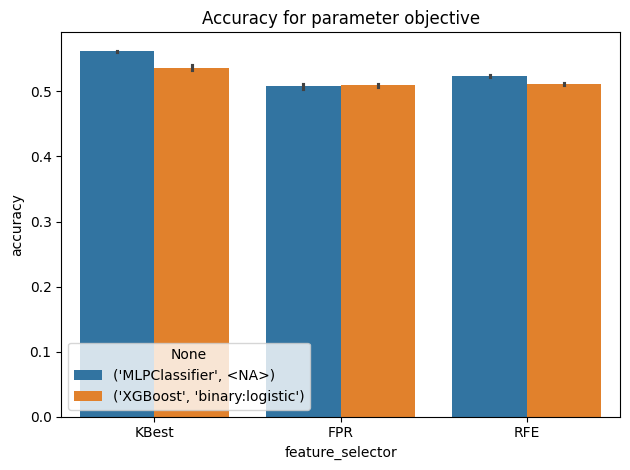

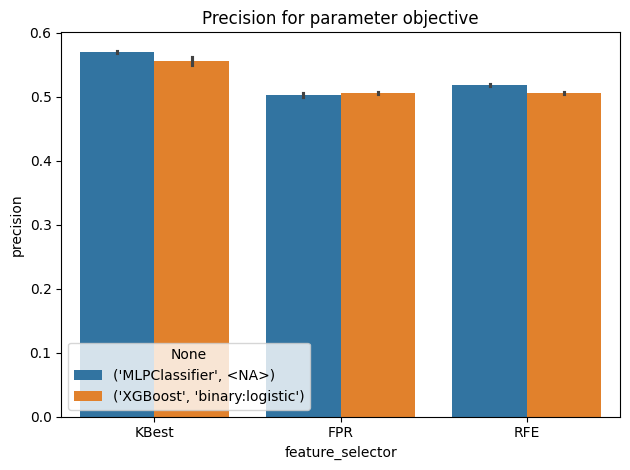

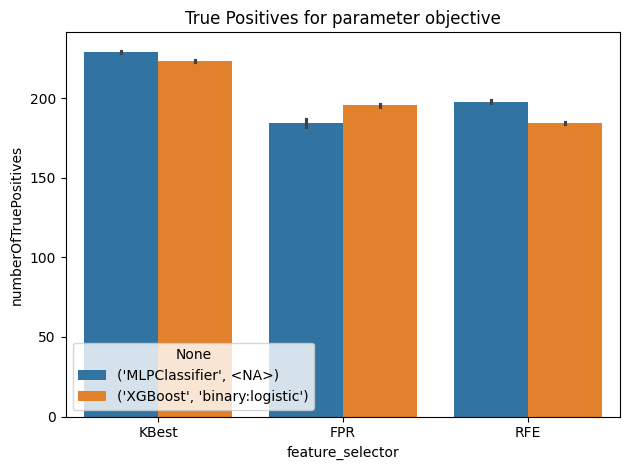

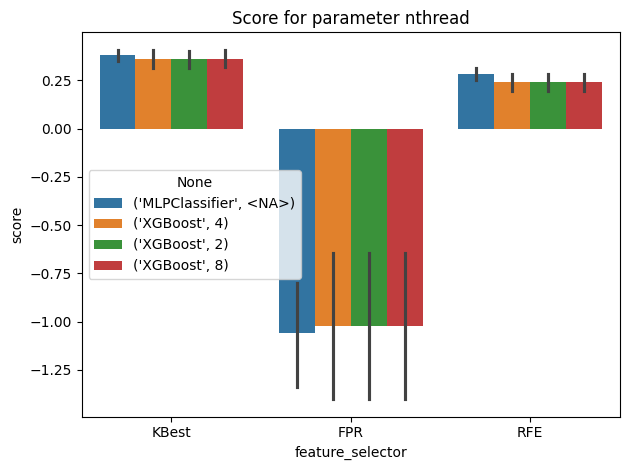

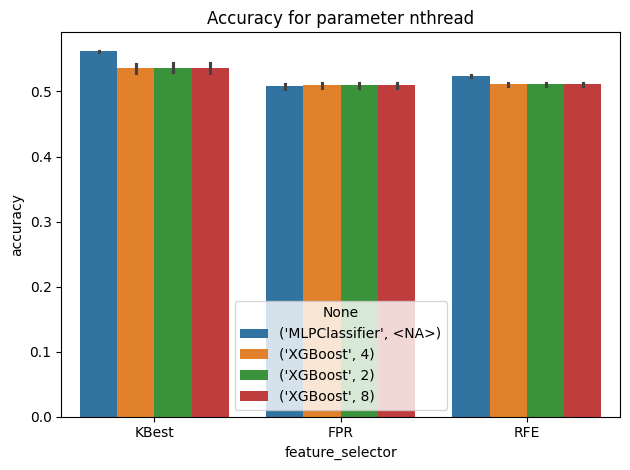

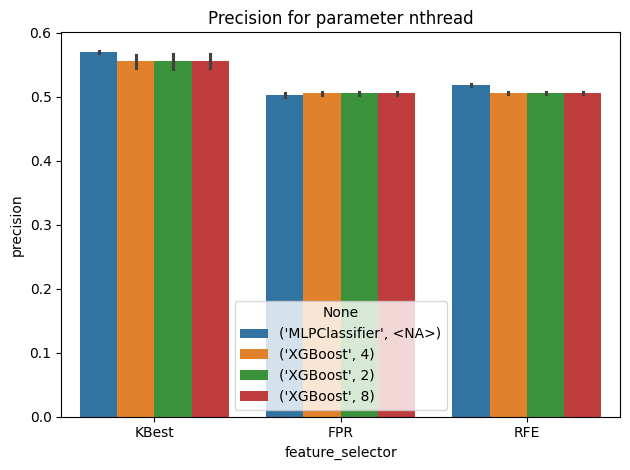

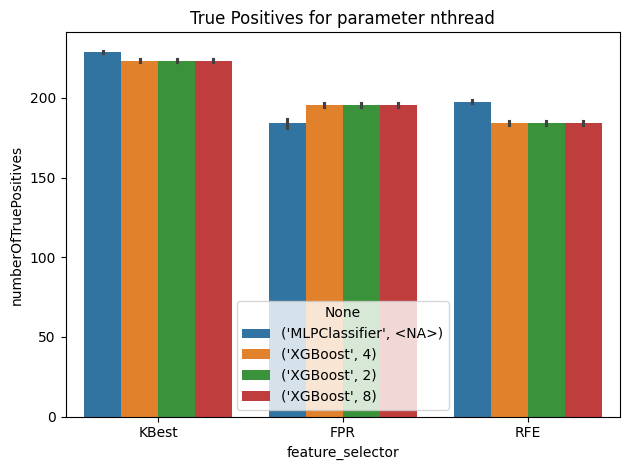

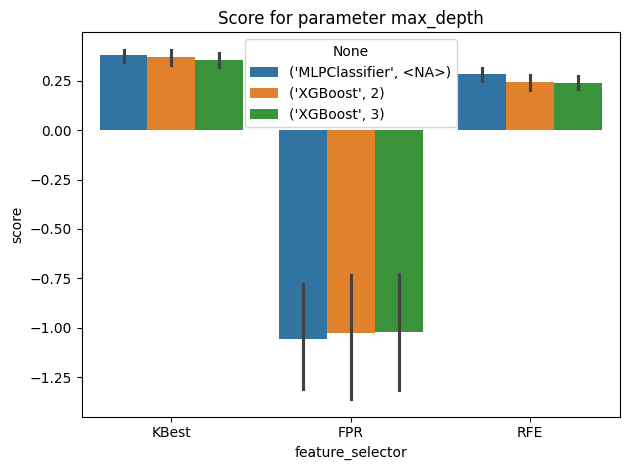

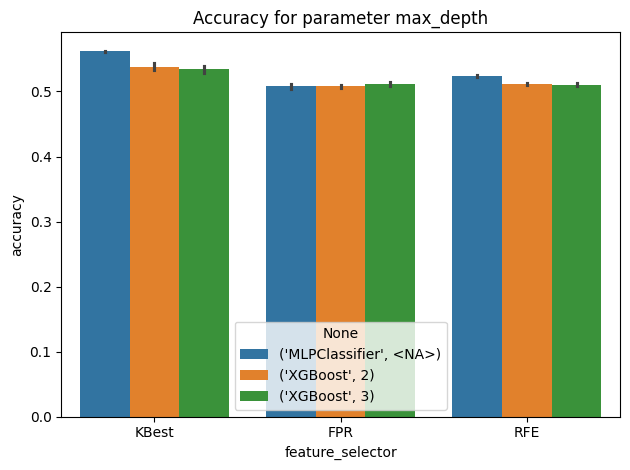

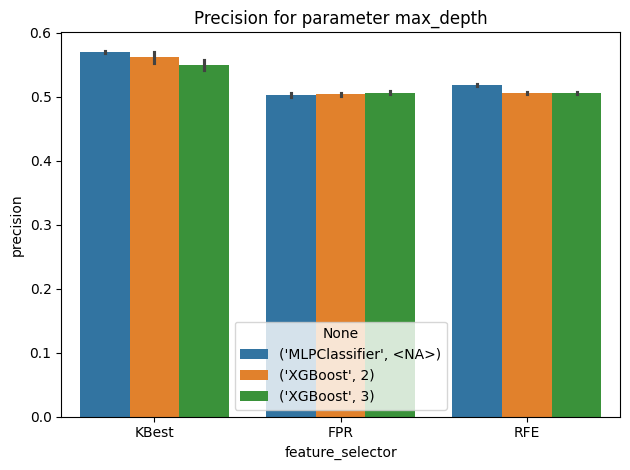

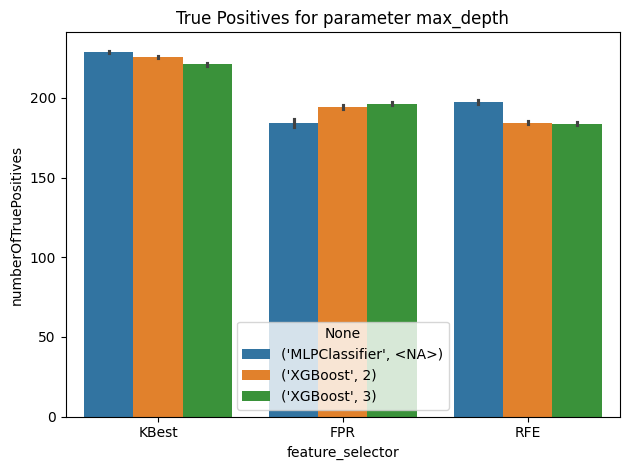

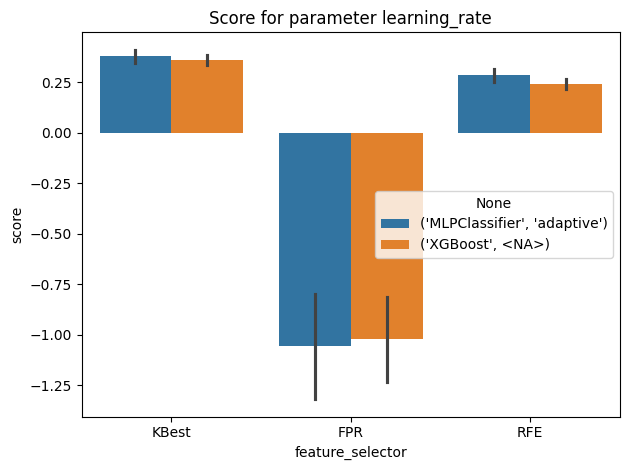

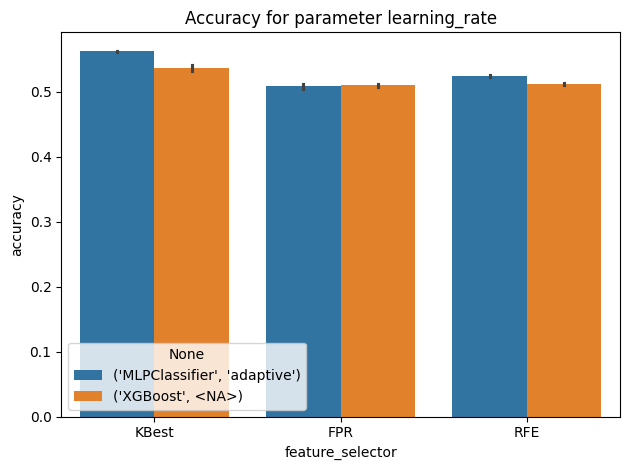

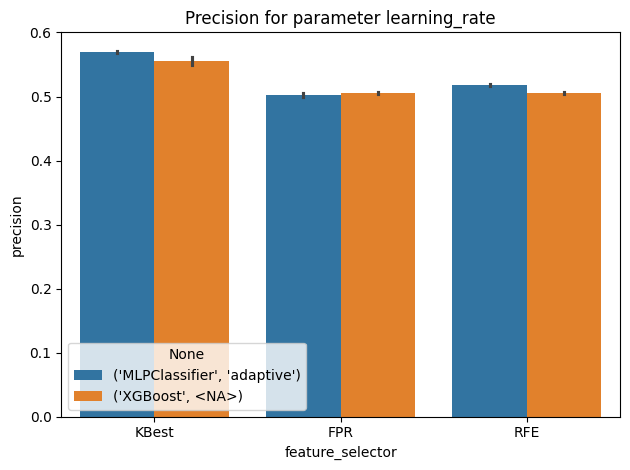

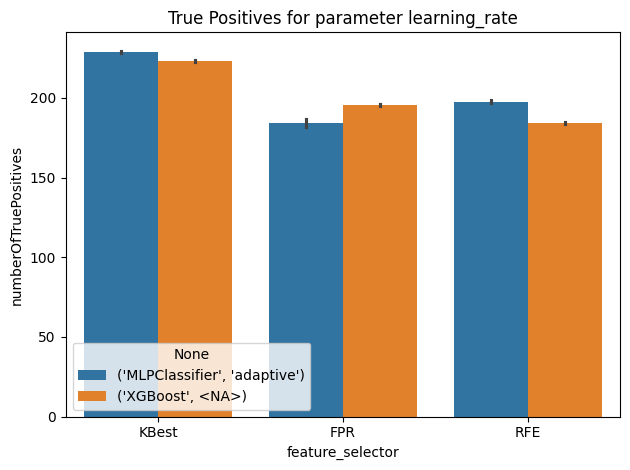

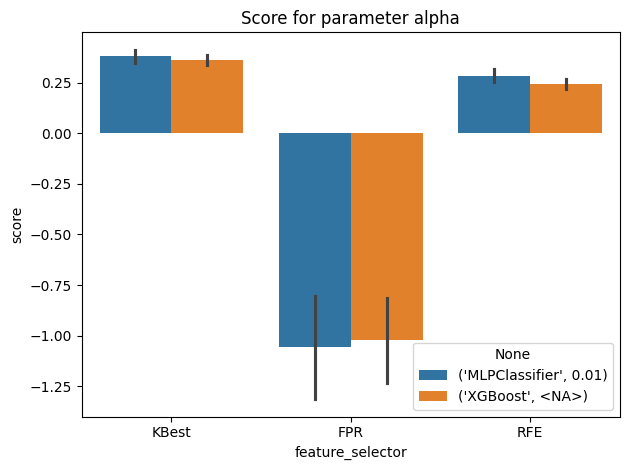

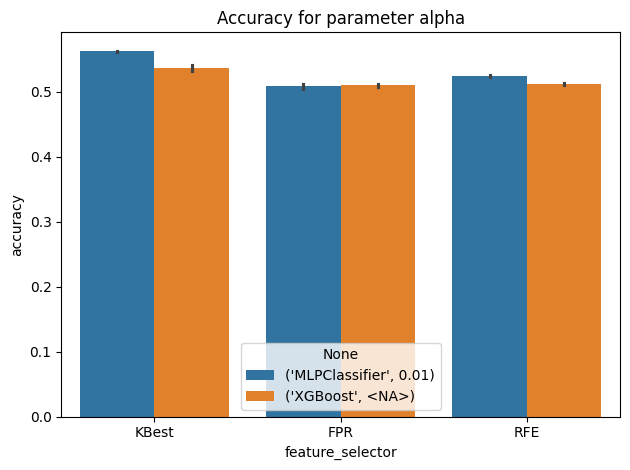

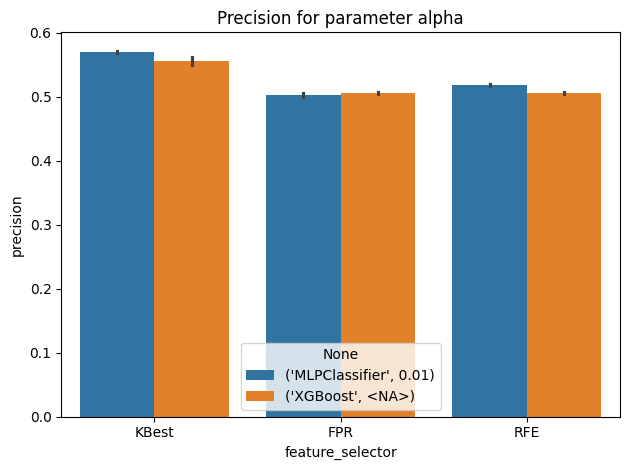

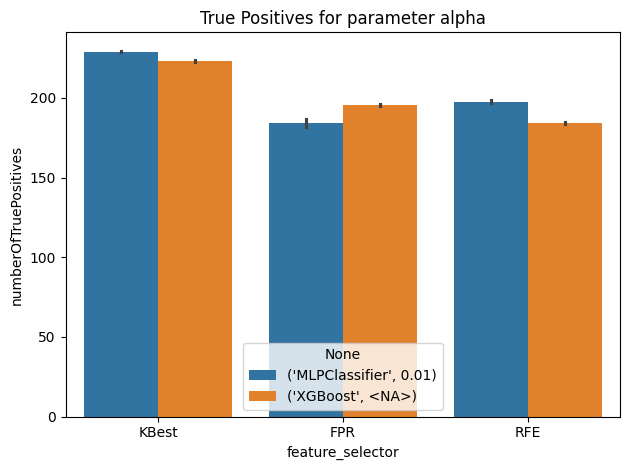

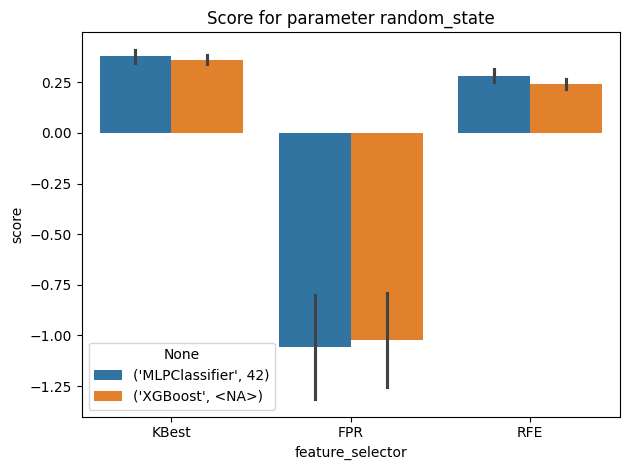

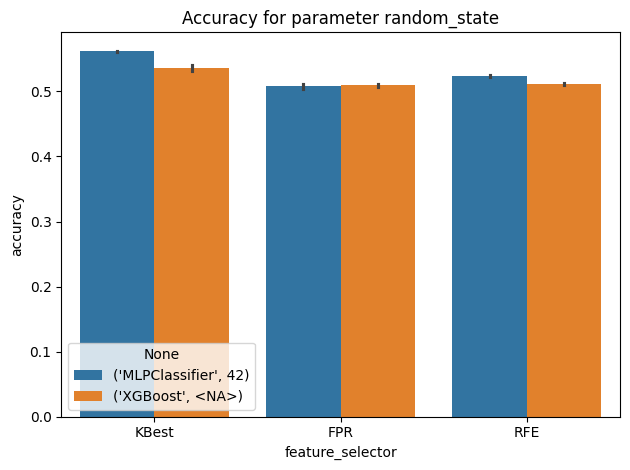

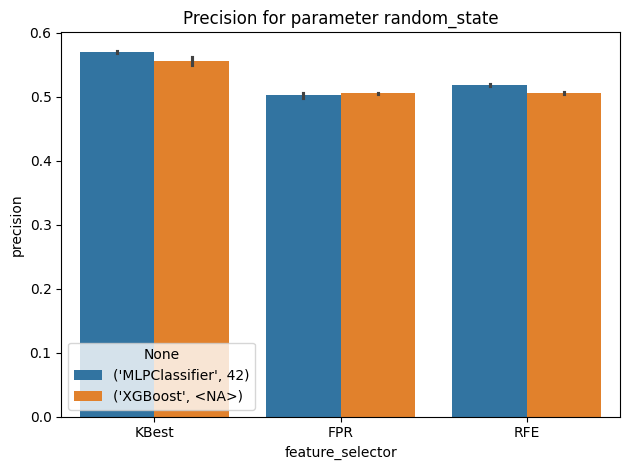

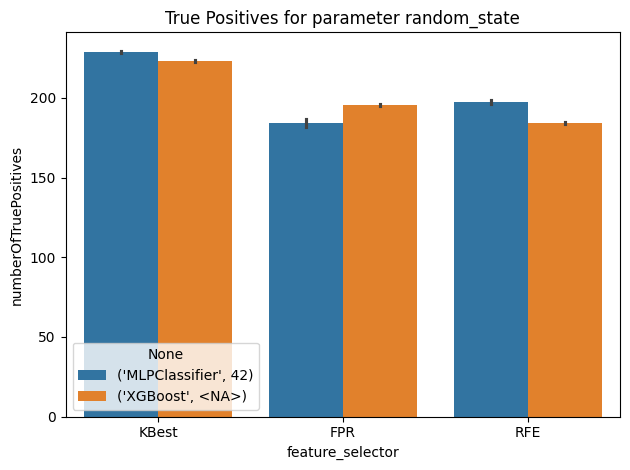

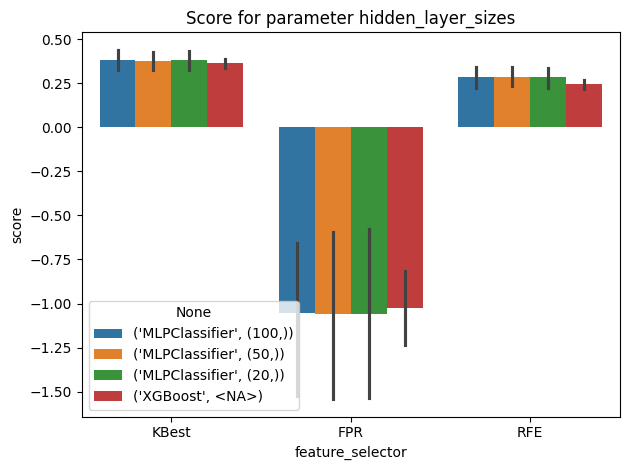

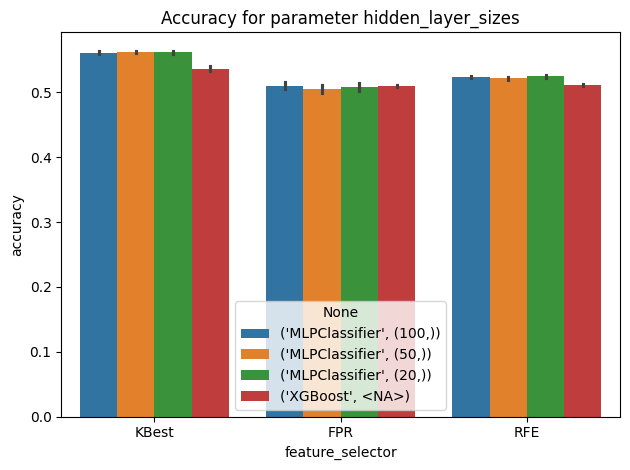

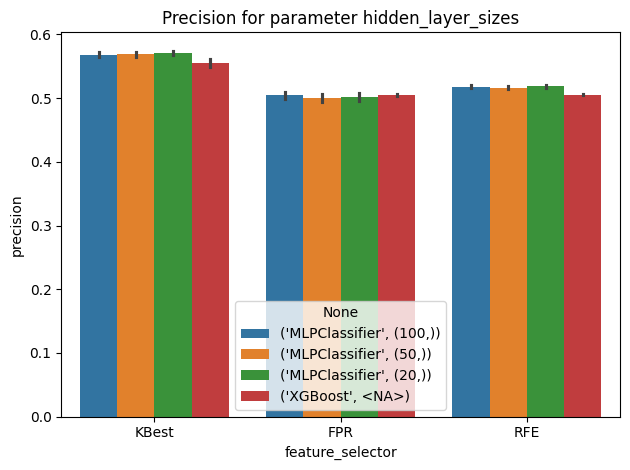

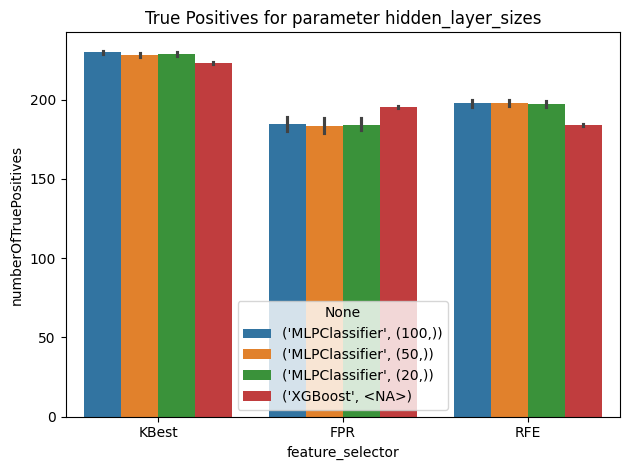

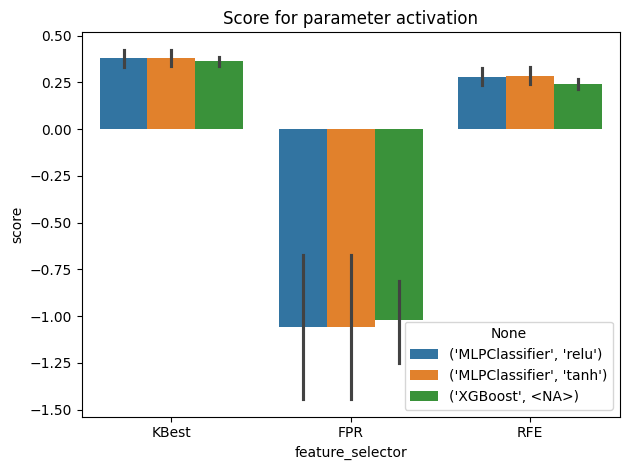

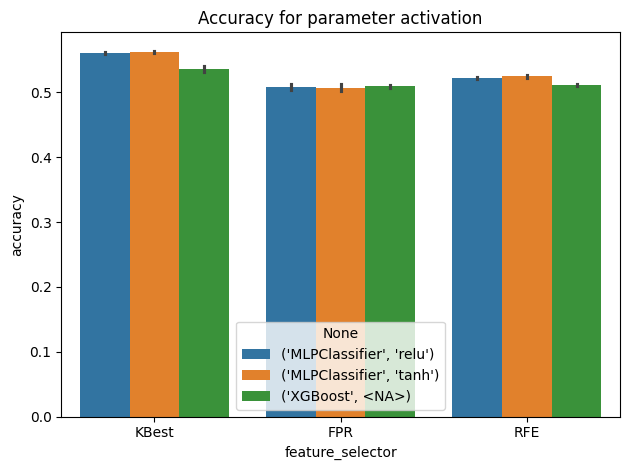

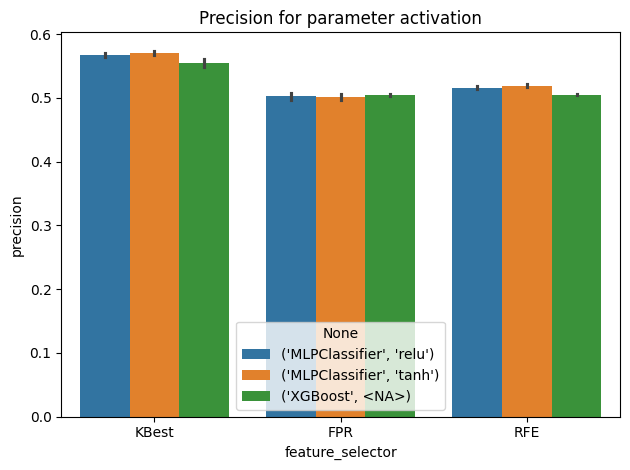

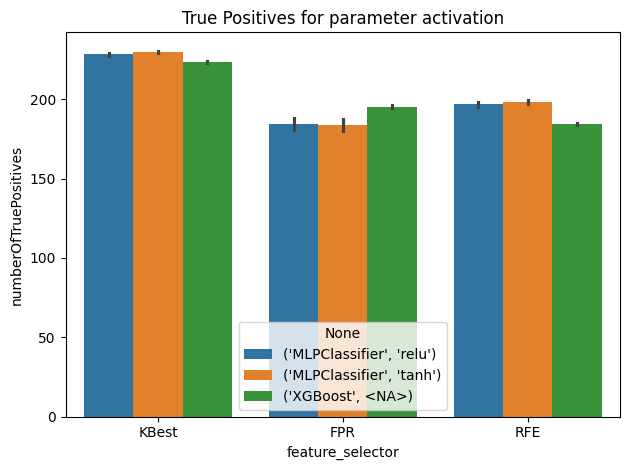

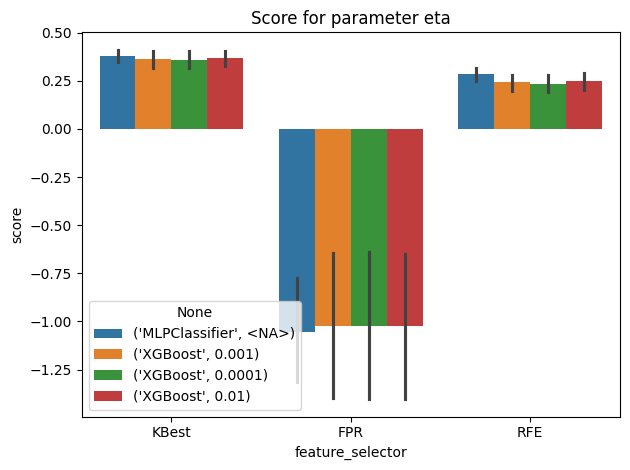

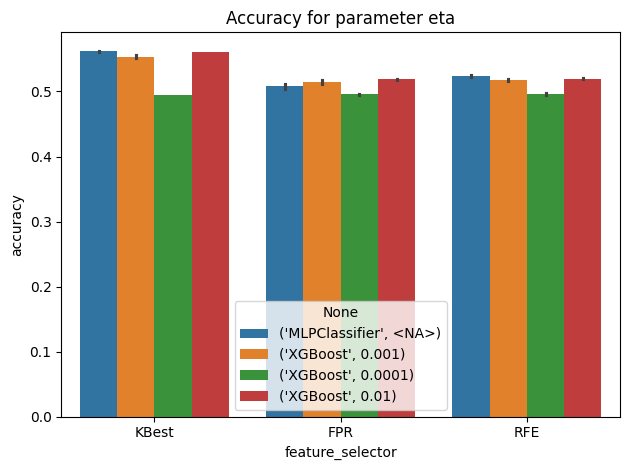

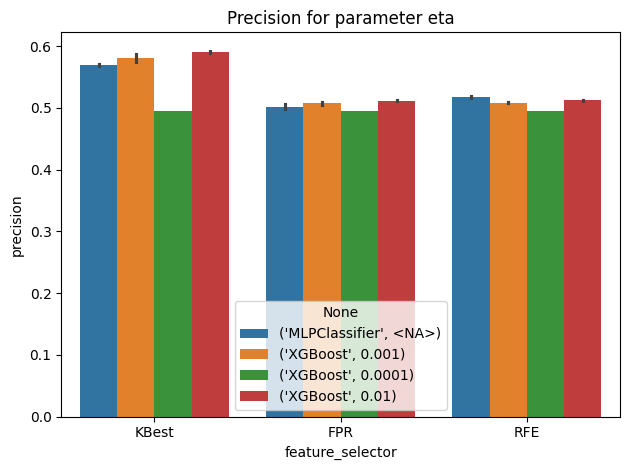

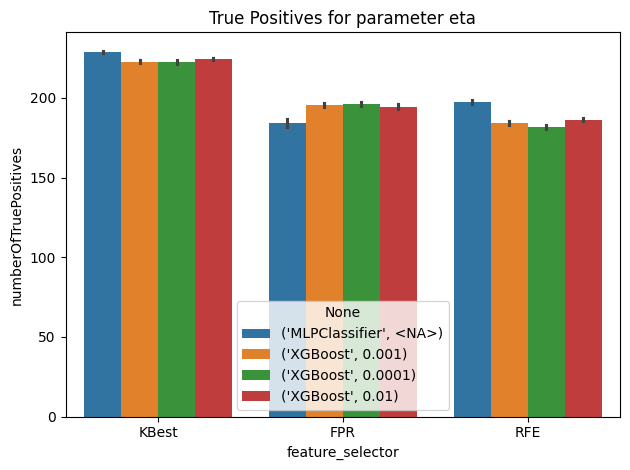

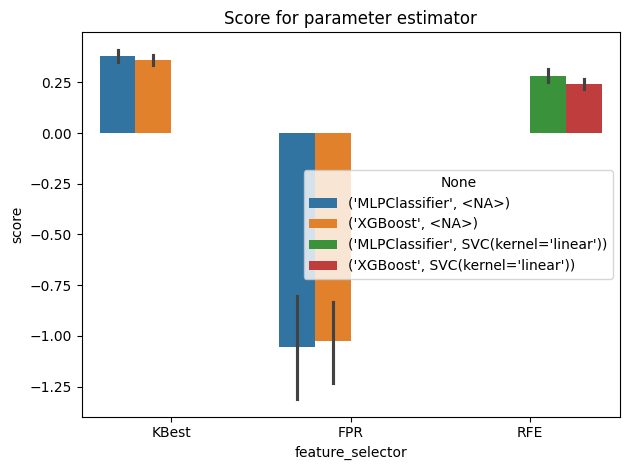

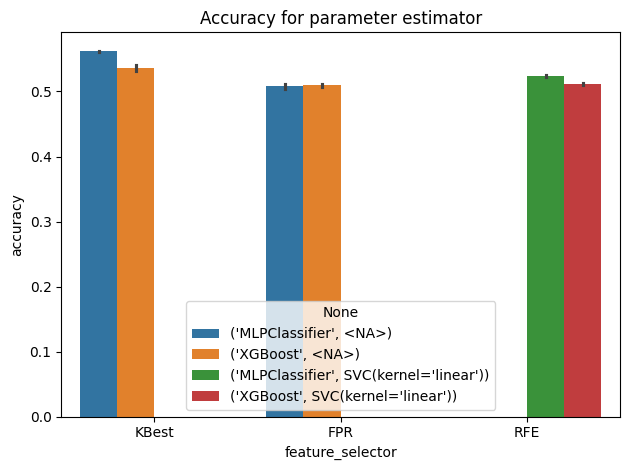

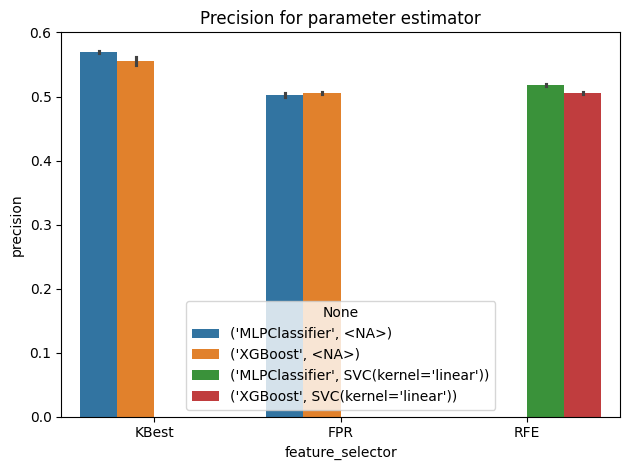

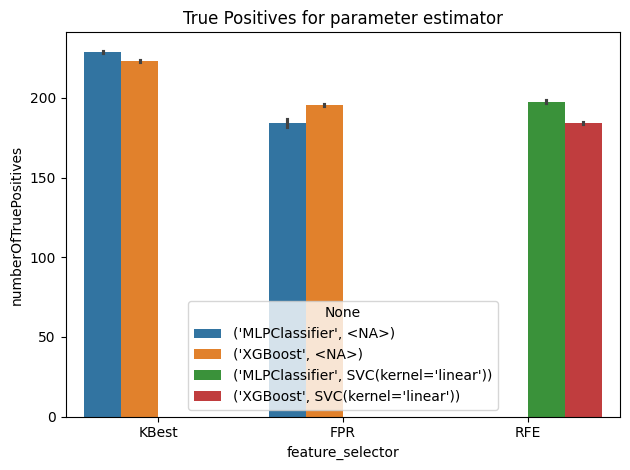

TypeError: boolean value of NA is ambiguous

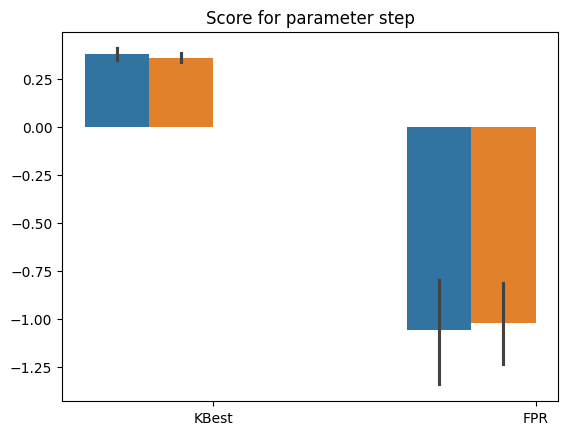

In [12]:
%%time
processedResultsDf, parameters = functions.extractParameterResultsArr(
    resultsDf,
    [models, featureSelectors, scalers, featureGenerators],
    [
        "model_parameters",
        "selector_parameters",
        "scaler_parameters",
        "feature_generator_parameters",
    ],
)
functions.drawParameterResultsBarplot(processedResultsDf, parameters)

### Score/Accuracy by number of features

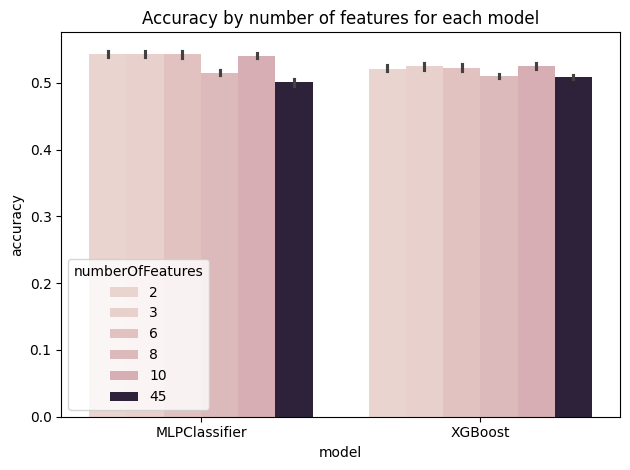

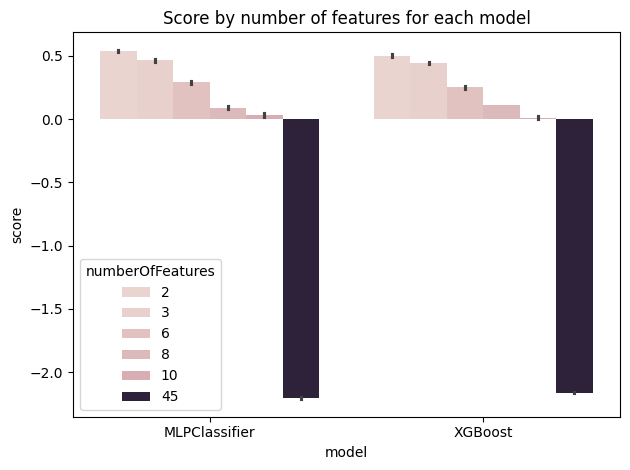

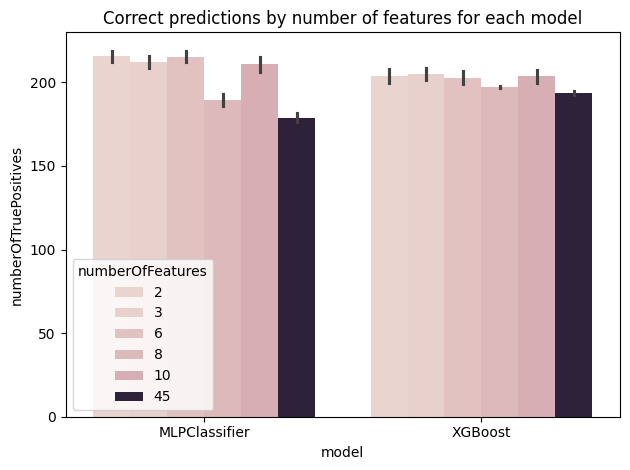

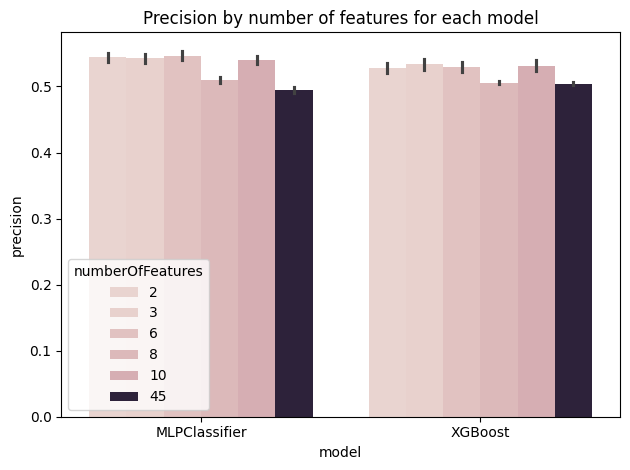

In [13]:
functions.drawResultsPerNumberOfFeatures(processedResultsDf)

### Final Results for Feature Selectors

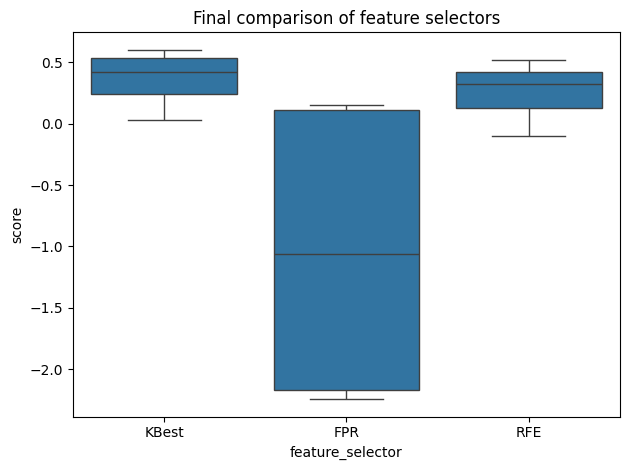

In [14]:
plt.title("Final comparison of feature selectors")
sns.boxplot(data=processedResultsDf, x="feature_selector", y="score")

plt.tight_layout()
plt.show()

<Axes: xlabel='model', ylabel='score'>

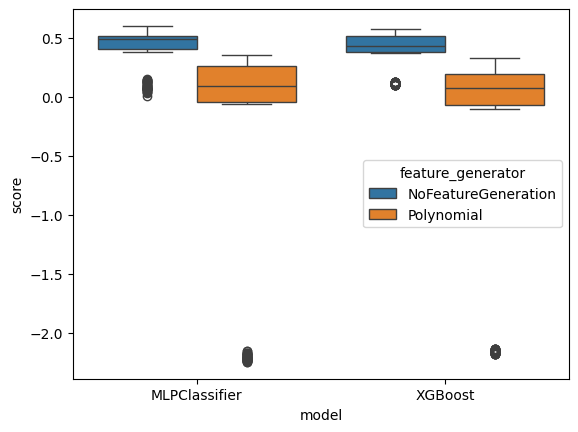

In [15]:
sns.boxplot(data=processedResultsDf, x="model", y="score", hue="feature_generator")

<Axes: xlabel='model', ylabel='score'>

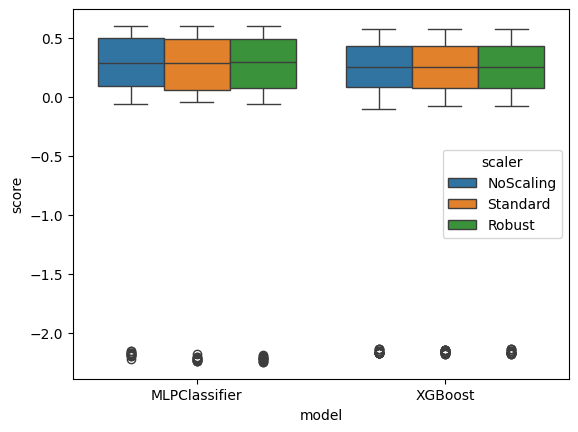

In [16]:
sns.boxplot(data=processedResultsDf, x="model", y="score", hue="scaler")

### Final Results for Models

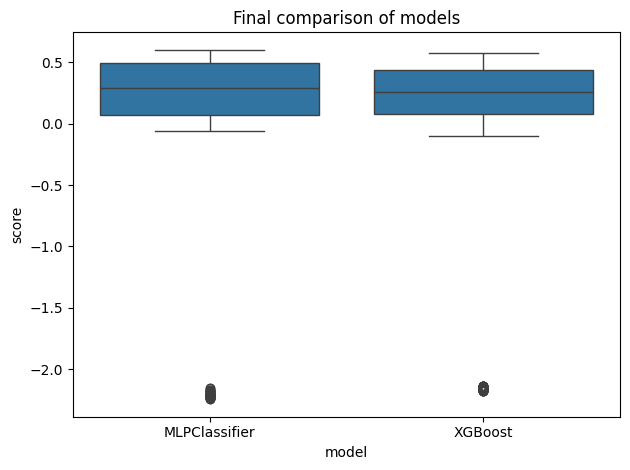

In [17]:
plt.title("Final comparison of models")
sns.boxplot(data=processedResultsDf, x="model", y="score")
plt.tight_layout()
plt.show()

### Final Results

In [18]:
%%time
filteredDf = functions.filterDataframeByBestResults(processedResultsDf)

CPU times: total: 0 ns
Wall time: 0 ns


In [30]:
processedResultsDf[
    processedResultsDf["model"] == functions.ModelType.XGBoost.name
].sort_values(by="score", ascending=False).head(5)

,score,numberOfTruePositives,accuracy,precision,numberOfFeatures,model,model_parameters,feature_selector,selector_parameters,scaler,...,model_parameters_hidden_layer_sizes,model_parameters_activation,model_parameters_eta,selector_parameters_estimator,selector_parameters_step,selector_parameters_score_func,selector_parameters_k,selector_parameters_n_features_to_select,selector_parameters_alpha,feature_generator_parameters_degree
12,0.574924,228,0.557576,0.600467,2,XGBoost,"{'max_depth': 2, 'eta': 0.001, 'objective': 'b...",KBest,{'score_func': <function mutual_info_classif a...,NoScaling,...,<NA>,<NA>,0.001,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
13,0.574924,228,0.557576,0.600467,2,XGBoost,"{'max_depth': 2, 'eta': 0.001, 'objective': 'b...",KBest,{'score_func': <function mutual_info_classif a...,NoScaling,...,<NA>,<NA>,0.001,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
134,0.574924,228,0.557576,0.600467,2,XGBoost,"{'max_depth': 2, 'eta': 0.001, 'objective': 'b...",KBest,{'score_func': <function mutual_info_classif a...,Robust,...,<NA>,<NA>,0.001,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
135,0.574924,228,0.494545,0.494545,2,XGBoost,"{'max_depth': 2, 'eta': 0.0001, 'objective': '...",KBest,{'score_func': <function mutual_info_classif a...,Robust,...,<NA>,<NA>,0.0001,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
136,0.574924,228,0.494545,0.494545,2,XGBoost,"{'max_depth': 2, 'eta': 0.0001, 'objective': '...",KBest,{'score_func': <function mutual_info_classif a...,Robust,...,<NA>,<NA>,0.0001,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>


In [19]:
processedResultsDf[
    processedResultsDf["scaler"] == functions.Scaler.NoScaling.name
].sort_values(by="score", ascending=False).head(5)

,score,numberOfTruePositives,accuracy,precision,numberOfFeatures,model,model_parameters,feature_selector,selector_parameters,scaler,...,model_parameters_hidden_layer_sizes,model_parameters_activation,model_parameters_eta,selector_parameters_estimator,selector_parameters_step,selector_parameters_score_func,selector_parameters_k,selector_parameters_n_features_to_select,selector_parameters_alpha,feature_generator_parameters_degree
8,0.602446,237,0.560606,0.570325,2,MLPClassifier,"{'activation': 'tanh', 'solver': 'adam', 'alph...",KBest,{'score_func': <function mutual_info_classif a...,NoScaling,...,"(20,)",tanh,<NA>,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
3,0.590214,233,0.560000,0.564286,2,MLPClassifier,"{'activation': 'relu', 'solver': 'adam', 'alph...",KBest,{'score_func': <function mutual_info_classif a...,NoScaling,...,"(100,)",relu,<NA>,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
0,0.584098,231,0.561212,0.574194,2,MLPClassifier,"{'activation': 'relu', 'solver': 'adam', 'alph...",KBest,{'score_func': <function mutual_info_classif a...,NoScaling,...,"(100,)",relu,<NA>,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
10,0.584098,231,0.569091,0.573018,2,MLPClassifier,"{'activation': 'tanh', 'solver': 'adam', 'alph...",KBest,{'score_func': <function mutual_info_classif a...,NoScaling,...,"(50,)",tanh,<NA>,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
4,0.584098,231,0.560606,0.566423,2,MLPClassifier,"{'activation': 'relu', 'solver': 'adam', 'alph...",KBest,{'score_func': <function mutual_info_classif a...,NoScaling,...,"(50,)",relu,<NA>,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>


In [20]:
filteredDf["scaler"]

8      NoScaling
68      Standard
128       Robust
Name: scaler, dtype: object

In [21]:
filteredDf["model_parameters"].to_numpy()

array([{'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (20,), 'max_iter': 1600, 'random_state': 42},
       {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (20,), 'max_iter': 1600, 'random_state': 42},
       {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (20,), 'max_iter': 1600, 'random_state': 42}],
      dtype=object)

In [22]:
filteredDf["feature_generator"]

8      NoFeatureGeneration
68     NoFeatureGeneration
128    NoFeatureGeneration
Name: feature_generator, dtype: object

In [23]:
filteredDf

,score,numberOfTruePositives,accuracy,precision,numberOfFeatures,model,model_parameters,feature_selector,selector_parameters,scaler,...,model_parameters_hidden_layer_sizes,model_parameters_activation,model_parameters_eta,selector_parameters_estimator,selector_parameters_step,selector_parameters_score_func,selector_parameters_k,selector_parameters_n_features_to_select,selector_parameters_alpha,feature_generator_parameters_degree
8,0.602446,237,0.560606,0.570325,2,MLPClassifier,"{'activation': 'tanh', 'solver': 'adam', 'alph...",KBest,{'score_func': <function mutual_info_classif a...,NoScaling,...,"(20,)",tanh,<NA>,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
68,0.602446,237,0.561212,0.571207,2,MLPClassifier,"{'activation': 'tanh', 'solver': 'adam', 'alph...",KBest,{'score_func': <function mutual_info_classif a...,Standard,...,"(20,)",tanh,<NA>,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
128,0.602446,237,0.560606,0.571205,2,MLPClassifier,"{'activation': 'tanh', 'solver': 'adam', 'alph...",KBest,{'score_func': <function mutual_info_classif a...,Robust,...,"(20,)",tanh,<NA>,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>


In [24]:
%%time
filteredDf = functions.filterDataframeByBestResults(processedResultsDf)

CPU times: total: 0 ns
Wall time: 0 ns


In [25]:
processedResultsDf[
    processedResultsDf["scaler"] == functions.Scaler.NoScaling.name
].sort_values(by="score", ascending=False).head(5)

,score,numberOfTruePositives,accuracy,precision,numberOfFeatures,model,model_parameters,feature_selector,selector_parameters,scaler,...,model_parameters_hidden_layer_sizes,model_parameters_activation,model_parameters_eta,selector_parameters_estimator,selector_parameters_step,selector_parameters_score_func,selector_parameters_k,selector_parameters_n_features_to_select,selector_parameters_alpha,feature_generator_parameters_degree
8,0.602446,237,0.560606,0.570325,2,MLPClassifier,"{'activation': 'tanh', 'solver': 'adam', 'alph...",KBest,{'score_func': <function mutual_info_classif a...,NoScaling,...,"(20,)",tanh,<NA>,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
3,0.590214,233,0.560000,0.564286,2,MLPClassifier,"{'activation': 'relu', 'solver': 'adam', 'alph...",KBest,{'score_func': <function mutual_info_classif a...,NoScaling,...,"(100,)",relu,<NA>,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
0,0.584098,231,0.561212,0.574194,2,MLPClassifier,"{'activation': 'relu', 'solver': 'adam', 'alph...",KBest,{'score_func': <function mutual_info_classif a...,NoScaling,...,"(100,)",relu,<NA>,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
10,0.584098,231,0.569091,0.573018,2,MLPClassifier,"{'activation': 'tanh', 'solver': 'adam', 'alph...",KBest,{'score_func': <function mutual_info_classif a...,NoScaling,...,"(50,)",tanh,<NA>,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
4,0.584098,231,0.560606,0.566423,2,MLPClassifier,"{'activation': 'relu', 'solver': 'adam', 'alph...",KBest,{'score_func': <function mutual_info_classif a...,NoScaling,...,"(50,)",relu,<NA>,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>


In [26]:
filteredDf["scaler"]

8      NoScaling
68      Standard
128       Robust
Name: scaler, dtype: object

In [27]:
filteredDf["model_parameters"].to_numpy()

array([{'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (20,), 'max_iter': 1600, 'random_state': 42},
       {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (20,), 'max_iter': 1600, 'random_state': 42},
       {'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (20,), 'max_iter': 1600, 'random_state': 42}],
      dtype=object)

In [28]:
filteredDf["feature_generator"]

8      NoFeatureGeneration
68     NoFeatureGeneration
128    NoFeatureGeneration
Name: feature_generator, dtype: object

In [29]:
filteredDf

,score,numberOfTruePositives,accuracy,precision,numberOfFeatures,model,model_parameters,feature_selector,selector_parameters,scaler,...,model_parameters_hidden_layer_sizes,model_parameters_activation,model_parameters_eta,selector_parameters_estimator,selector_parameters_step,selector_parameters_score_func,selector_parameters_k,selector_parameters_n_features_to_select,selector_parameters_alpha,feature_generator_parameters_degree
8,0.602446,237,0.560606,0.570325,2,MLPClassifier,"{'activation': 'tanh', 'solver': 'adam', 'alph...",KBest,{'score_func': <function mutual_info_classif a...,NoScaling,...,"(20,)",tanh,<NA>,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
68,0.602446,237,0.561212,0.571207,2,MLPClassifier,"{'activation': 'tanh', 'solver': 'adam', 'alph...",KBest,{'score_func': <function mutual_info_classif a...,Standard,...,"(20,)",tanh,<NA>,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
128,0.602446,237,0.560606,0.571205,2,MLPClassifier,"{'activation': 'tanh', 'solver': 'adam', 'alph...",KBest,{'score_func': <function mutual_info_classif a...,Robust,...,"(20,)",tanh,<NA>,<NA>,<NA>,mutual_info_classif,2,<NA>,<NA>,<NA>
